In [38]:
#imports
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt

import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playerdashboardbyclutch, playergamelogs, commonplayerinfo, teamplayeronoffdetails, teamgamelogs


In [157]:
class Team(object):
    def __init__(self, TeamID):
        
        self.TeamID =  TeamID 
        self.TeamName = teams.find_team_name_by_id(team_id=self.TeamID)['full_name']

        self.StartYear = 2009 #First year data is avalible
        self.LastYear = 2021 #Current year
        
        
        #team abreviations and corresponding codes for data proccessing
        self.team_abbreviation_codes = {
            "ATL": 1,
            "BKN": 2,
            "BOS": 3,
            "CHA": 4,
            "CHI": 5,
            "CLE": 6,
            "DAL": 7,	
            "DEN": 8,
            "DET": 9,
            "GSW": 10,	
            "HOU": 11,	
            "IND": 12,
            "LAC": 13,	
            "LAL": 14,	
            "MEM": 15, 	
            "MIA": 16,	
            "MIL": 17,	
            "MIN": 18,	
            "NOP": 19,
            "NOH": 19,	
            "NYK": 20,	
            "OKC": 21,	
            "ORL": 22,	
            "PHI": 23,	
            "PHX": 24,	
            "POR": 25,	
            "SAC": 26,	
            "SAS": 27,	
            "TOR": 28,	
            "UTA": 29,	
            "WAS": 30
        }

        
    #Complile the Team Data
    def compile_active_team_data(self):
        

        matchup_raw_data = []
    
        team_season_point_average_raw_data = []
        team_points_raw_data = []
        opponent_season_point_average_raw_data = []
        opponent_season_points_raw_data = []
        
        
        print(self.StartYear, self.LastYear)
        for year in range((self.StartYear), (self.LastYear)):
            print("-------------------------------------------------")
            season = str(year) + "-" + str(((year+1)-2000))
            teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season)
            print(season)
            

            matchup_api_data = teamLogs.get_data_frames()[0]["MATCHUP"]
            team_season_points_api_data=teamLogs.get_data_frames()[0]["PTS"]
        

            print(teamLogs.get_data_frames()[0])


            team_season_points = []
            
            for game in range(0, len(teamLogs.get_data_frames()[0])):
        
                    
                    
                    team_points_raw_data.append(team_season_points_api_data[game])
                    
                    team_season_points.append(team_season_points_api_data[game])
                    if game == 0:
                        team_season_point_average_raw_data.append(teamLogs.get_data_frames()[0]["PTS"][game])
                    else:
                        team_season_point_average_raw_data.append((sum(team_season_points)/len(team_season_points)))
                        
                    
                    self.team_abbreviation = teams.find_team_name_by_id(team_id=self.TeamID)['abbreviation']
                    matchup_api_data[game] = matchup_api_data[game].replace('NOH', 'NOP')
                    matchup_api_data[game] = matchup_api_data[game].replace('NJN', 'BKN')
                
                    

                    try:   
                        
                        matchup_api_data[game] = matchup_api_data[game].replace(self.team_abbreviation, "")
                        
                    except:
                        print("Unexpected Error with removing player team")
                    try:
                        matchup_api_data[game] = matchup_api_data[game].replace(" @ ", "")
                        matchup_api_data[game] = matchup_api_data[game].replace(" vs. ", "")
                    except:
                        print("Error")
                    
                    
                    
                    opponentAbbreviation = matchup_api_data[game]
                    
                    matchup_api_data[game] = self.team_abbreviation_codes[opponentAbbreviation]
                    matchup_raw_data.append(matchup_api_data[game])
                    
                    opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation)["id"])
                    if (game%10==0):
                        print(game)
                        
                    opponentLogs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=season)
                    opponent_season_points_api_data = opponentLogs.get_data_frames()[0]['PTS']
                    if game == 0:
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data[game])
                    elif game<(len(opponentLogs.get_data_frames()[0]['PTS'])):
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data.head(game).mean())
                    else:
                        opponent_season_point_average_raw_data.append(opponent_season_points_api_data.mean())
                                            
                    time.sleep(1)
                    

        #Lengths of lists used for troublshooting
        print("the lengths")
        print(len(team_points_raw_data))
        print(len(matchup_raw_data))
        print(len(team_season_point_average_raw_data))
        print(len(opponent_season_point_average_raw_data))
        
        #adding the lists to the team data dictionary to be made into a dataframe
        team_data = {
        "Points Scored": team_points_raw_data,
        "Matchup": matchup_raw_data,
        "Team Point Average" : team_season_point_average_raw_data,
        "Opponent Team Point Average": opponent_season_point_average_raw_data 
        }

        team_dataFrame = pd.DataFrame(data=team_data)
        print(team_dataFrame) #print for troublshooting

        return(team_dataFrame)


    def process_active_team_data(self,data_for_processing):
        data = data_for_processing
        opponent_processing = data.pop('Matchup')

        data["ATL"] = (opponent_processing == 1)*1.0
        data["BKN"] = (opponent_processing == 2)*1.0
        data["BOS"] = (opponent_processing == 3)*1.0
        data["CHA"] = (opponent_processing == 4)*1.0
        data["CHI"] = (opponent_processing == 5)*1.0
        data["CLE"] = (opponent_processing == 6)*1.0
        data["DAL"] = (opponent_processing == 7)*1.0
        data["DEN"] = (opponent_processing == 8)*1.0
        data["DET"] = (opponent_processing == 9)*1.0
        data["GSW"] = (opponent_processing == 10)*1.0
        data["HOU"] = (opponent_processing == 11)*1.0
        data["IND"] = (opponent_processing == 12)*1.0
        data["LAC"] = (opponent_processing == 13)*1.0
        data["LAL"] = (opponent_processing == 14)*1.0
        data["MEM"] = (opponent_processing == 15)*1.0
        data["MIA"] = (opponent_processing == 16)*1.0
        data["MIL"] = (opponent_processing == 17)*1.0
        data["MIN"] = (opponent_processing == 18)*1.0
        data["NOP"] = (opponent_processing == 19)*1.0
        data["NYK"] = (opponent_processing == 20)*1.0
        data["OKC"] = (opponent_processing == 21)*1.0
        data["ORL"] = (opponent_processing == 22)*1.0
        data["PHI"] = (opponent_processing == 23)*1.0
        data["PHX"] = (opponent_processing == 24)*1.0
        data["POR"] = (opponent_processing== 25)*1.0
        data["SAC"] = (opponent_processing == 26)*1.0
        data["SAS"] = (opponent_processing == 27)*1.0
        data["TOR"] = (opponent_processing == 28)*1.0
        data["UTA"] = (opponent_processing == 29)*1.0
        data["WAS"] = (opponent_processing == 30)*1.0		


        data = data.drop(columns=[self.team_abbreviation])

        return(data)
       
    #Get the Team data for outside calls
    def get_active_team_data(self):
        compiled_data = self.compile_active_team_data()
        return(self.process_active_team_data(compiled_data))
    def compile_data_for_prediction(self, opponentAbbreviation_for_prediction):
        print(22222)
        season = "2020-21"
        teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season)
        team_season_points_api_data = teamLogs.get_data_frames()[0]["PTS"]
        print(team_season_points_api_data)
        team_season_point_average = [team_season_points_api_data.mean()]
        
        print(77777777777777777777777777777777777777777, team_season_point_average)
        opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation_for_prediction)["id"])
        opponentLogs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=season)
        opponent_season_points_api_data = opponentLogs.get_data_frames()[0]["PTS"]
        opponent_season_point_average = [opponent_season_points_api_data.mean()]

        opponent_code = self.team_abbreviation_codes[opponentAbbreviation_for_prediction]
        
        prediction_data = {
        "Matchup": [opponent_code],
        "Team Point Average" : team_season_point_average,
        "Opponent Team Point Average": opponent_season_point_average
        }
        prediction_dataframe = pd.DataFrame(data=prediction_data)
        
        print(prediction_dataframe)
        return(prediction_dataframe)
        
    def get_data_for_prediction(self, opponentAbbreviation_for_prediction):
        compiled_data = self.compile_data_for_prediction(opponentAbbreviation_for_prediction)
        print("Here is the result", )
        return(self.process_active_team_data(compiled_data))
    



In [158]:
team =Team(1610612763) 
test = team.get_active_team_data() 




    


print(test)




2009 2021
-------------------------------------------------
2009-10
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION          TEAM_NAME     GAME_ID  \
0      2009-10  1610612763               MEM  Memphis Grizzlies  0020901224   
1      2009-10  1610612763               MEM  Memphis Grizzlies  0020901209   
2      2009-10  1610612763               MEM  Memphis Grizzlies  0020901190   
3      2009-10  1610612763               MEM  Memphis Grizzlies  0020901185   
4      2009-10  1610612763               MEM  Memphis Grizzlies  0020901167   
..         ...         ...               ...                ...         ...   
77     2009-10  1610612763               MEM  Memphis Grizzlies  0020900069   
78     2009-10  1610612763               MEM  Memphis Grizzlies  0020900049   
79     2009-10  1610612763               MEM  Memphis Grizzlies  0020900043   
80     2009-10  1610612763               MEM  Memphis Grizzlies  0020900025   
81     2009-10  1610612763               MEM  Memphis Grizzlies

10
20
30
40
50
60
-------------------------------------------------
2012-13
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION          TEAM_NAME     GAME_ID  \
0      2012-13  1610612763               MEM  Memphis Grizzlies  0021201223   
1      2012-13  1610612763               MEM  Memphis Grizzlies  0021201208   
2      2012-13  1610612763               MEM  Memphis Grizzlies  0021201192   
3      2012-13  1610612763               MEM  Memphis Grizzlies  0021201184   
4      2012-13  1610612763               MEM  Memphis Grizzlies  0021201159   
..         ...         ...               ...                ...         ...   
77     2012-13  1610612763               MEM  Memphis Grizzlies  0021200073   
78     2012-13  1610612763               MEM  Memphis Grizzlies  0021200057   
79     2012-13  1610612763               MEM  Memphis Grizzlies  0021200045   
80     2012-13  1610612763               MEM  Memphis Grizzlies  0021200026   
81     2012-13  1610612763               MEM  Memphis G

10
20
30
40
50
60
70
80
-------------------------------------------------
2015-16
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION          TEAM_NAME     GAME_ID  \
0      2015-16  1610612763               MEM  Memphis Grizzlies  0021501227   
1      2015-16  1610612763               MEM  Memphis Grizzlies  0021501216   
2      2015-16  1610612763               MEM  Memphis Grizzlies  0021501190   
3      2015-16  1610612763               MEM  Memphis Grizzlies  0021501185   
4      2015-16  1610612763               MEM  Memphis Grizzlies  0021501158   
..         ...         ...               ...                ...         ...   
77     2015-16  1610612763               MEM  Memphis Grizzlies  0021500058   
78     2015-16  1610612763               MEM  Memphis Grizzlies  0021500051   
79     2015-16  1610612763               MEM  Memphis Grizzlies  0021500036   
80     2015-16  1610612763               MEM  Memphis Grizzlies  0021500018   
81     2015-16  1610612763               MEM  Mem

10
20
30
40
50
60
70
80
-------------------------------------------------
2018-19
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION          TEAM_NAME     GAME_ID  \
0      2018-19  1610612763               MEM  Memphis Grizzlies  0021801225   
1      2018-19  1610612763               MEM  Memphis Grizzlies  0021801210   
2      2018-19  1610612763               MEM  Memphis Grizzlies  0021801201   
3      2018-19  1610612763               MEM  Memphis Grizzlies  0021801187   
4      2018-19  1610612763               MEM  Memphis Grizzlies  0021801175   
..         ...         ...               ...                ...         ...   
77     2018-19  1610612763               MEM  Memphis Grizzlies  0021800080   
78     2018-19  1610612763               MEM  Memphis Grizzlies  0021800061   
79     2018-19  1610612763               MEM  Memphis Grizzlies  0021800045   
80     2018-19  1610612763               MEM  Memphis Grizzlies  0021800020   
81     2018-19  1610612763               MEM  Mem

10
20
30
the lengths
909
909
909
909
     Points Scored  Matchup  Team Point Average  Opponent Team Point Average
0              105       21          105.000000                   114.000000
1              101        8          103.000000                   101.000000
2              101       23          102.333333                   108.000000
3              107       27          103.500000                   108.666667
4               84        7           99.600000                   105.500000
..             ...      ...                 ...                          ...
904            108        4          111.321429                   114.518519
905            107        3          111.172414                   111.214286
906            116        2          111.333333                   121.551724
907            112        1          111.354839                   111.133333
908            119       27          111.593750                   110.322581

[909 rows x 4 columns]
     Points Sco

In [159]:
backup = test
backup

,Points Scored,Team Point Average,Opponent Team Point Average,ATL,BKN,BOS,CHA,CHI,CLE,DAL,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
0,105,105.000000,114.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101,103.000000,101.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101,102.333333,108.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,107,103.500000,108.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,84,99.600000,105.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,108,111.321429,114.518519,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
905,107,111.172414,111.214286,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
906,116,111.333333,121.551724,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907,112,111.354839,111.133333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:

backup_two = backup
backup_two

,Team Point Average,Opponent Team Point Average,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
0,105.000000,114.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103.000000,101.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102.333333,108.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,103.500000,108.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,99.600000,105.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,111.321429,114.518519,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
905,111.172414,111.214286,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
906,111.333333,121.551724,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907,111.354839,111.133333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
class Prediction(object):
    
    def __init__(self, data):
        self.data= data
        
    def sigmoid(self, dataframe):
        
        return((dataframe - self.train_stats['mean'])/self.train_stats['std'])
        #Defining the model
    def build_model(self):
        #below comented out portion is another model under testing
        '''
        input_layer=tf.keras.layers.Input(([len(self.train_dataset.keys())]))
        densel_layer = tf.keras.layers.Dense(units=1, input_shape=([len(self.train_dataset.keys())],))
        output = densel_layer(input_layer)
        model = tf.keras.Model(inputs=input_layer,outputs=output)

        model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(0.1), metrics=['mae', 'mse'])

        
        '''
        print([len(self.train_dataset.keys())])
        model = keras.Sequential([

            layers.Dense(15, activation=tf.nn.relu, input_shape=[len(self.train_dataset.keys())]),
            layers.Dense(25, activation=tf.nn.relu),
            layers.Dense(1)
        ])

        optimizer = tf.keras.optimizers.RMSprop(0.001)

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])

        
        return model

    def test_prediction_accuracy(self):
        self.train_dataset = self.data.sample(frac=0.90, random_state=0)
        self.test_dataset = self.data.drop(self.train_dataset.index)
    
        self.train_labels = self.train_dataset.pop("Points Scored")
        self.test_labels = self.test_dataset.pop("Points Scored")
        
        self.train_stats = self.train_dataset.describe()
        #self.train_stats.pop("Points Scored")
        self.train_stats = self.train_stats.transpose()
        
        normed_train_data = self.sigmoid(self.train_dataset)
        normed_test_data = self.sigmoid(self.test_dataset)

        model = self.build_model()
        model.summary()
        example_batch = normed_train_data
        print((example_batch.keys()))
        example_result = model.predict(example_batch)
        example_result

        EPOCHS = 1000
        early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        history = model.fit(normed_train_data, self.train_labels, epochs=EPOCHS, callbacks=[early_stop])

        loss, mae, mse = model.evaluate(normed_test_data, self.test_labels, verbose=0)

        print("Testing set Mean Abs Error: {:5.2f} Points Scored".format(mae))
        #make predictions and then plot them in realation to the actual values
        test_predictions = model.predict(normed_test_data).flatten()

        plt.scatter(self.test_labels, test_predictions)
        plt.xlabel("True Values [Points Scored]")
        plt.ylabel("Predictions [Points Scored]")
        plt.axis('equal')
        plt.axis('square')
        plt.xlim([60, plt.ylim()[1]])
        plt.ylim([60, plt.ylim()[1]])
        _ = plt.plot([-100,200], [-100, 200])

        print(self.test_labels)
        print(test_predictions)
    def make_prediction(self, prediction_circumstances):
        self.train_dataset = self.data
        print(self.data)
        self.train_labels = self.train_dataset.pop("Points Scored")
        
        self.train_stats = self.train_dataset.describe()
        #self.train_stats.pop("Points Scored")
        self.train_stats = self.train_stats.transpose()
        
        normed_train_data = self.sigmoid(self.train_dataset)
        normed_prediction_data = self.sigmoid(prediction_circumstances)
        model = self.build_model()
        model.summary()
        
        #following not nessicary
        example_batch = normed_train_data
        print((example_batch.keys()))
        example_result = model.predict(example_batch)
        example_result
        
        EPOCHS = 1000
        early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        history = model.fit(normed_train_data, self.train_labels, epochs=EPOCHS, callbacks=[early_stop])
        
        prediction = model.predict(normed_prediction_data).flatten()
        print(prediction)
        return(prediction)

     Points Scored  Team Point Average  Opponent Team Point Average  ATL  BKN  \
0              105          105.000000                   114.000000  0.0  0.0   
1              101          103.000000                   101.000000  0.0  0.0   
2              101          102.333333                   108.000000  0.0  0.0   
3              107          103.500000                   108.666667  0.0  0.0   
4               84           99.600000                   105.500000  0.0  0.0   
..             ...                 ...                          ...  ...  ...   
904            108          111.321429                   114.518519  0.0  0.0   
905            107          111.172414                   111.214286  0.0  0.0   
906            116          111.333333                   121.551724  0.0  1.0   
907            112          111.354839                   111.133333  1.0  0.0   
908            119          111.593750                   110.322581  0.0  0.0   

     BOS  CHA  CHI  CLE  DA

26/26 [==============================] - 0s 2ms/step - loss: 99.1958 - mae: 8.0525 - mse: 99.1958
Epoch 45/1000
26/26 [==============================] - 0s 2ms/step - loss: 100.5988 - mae: 8.1155 - mse: 100.5988
Epoch 46/1000
26/26 [==============================] - 0s 3ms/step - loss: 100.8712 - mae: 8.0921 - mse: 100.8712
Epoch 47/1000
26/26 [==============================] - 0s 1ms/step - loss: 105.2794 - mae: 8.4478 - mse: 105.2794
Epoch 48/1000
26/26 [==============================] - 0s 1ms/step - loss: 96.1097 - mae: 7.9259 - mse: 96.1097
Epoch 49/1000
26/26 [==============================] - 0s 1ms/step - loss: 102.2386 - mae: 8.1603 - mse: 102.2386
Epoch 50/1000
26/26 [==============================] - 0s 1ms/step - loss: 107.3085 - mae: 8.4042 - mse: 107.3085
Epoch 51/1000
26/26 [==============================] - 0s 1ms/step - loss: 103.1109 - mae: 8.1021 - mse: 103.1109
Epoch 52/1000
26/26 [==============================] - 0s 1ms/step - loss: 102.8332 - mae: 8.0332 - mse: 1

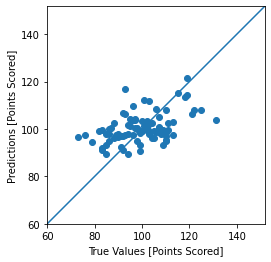

In [165]:
print(test)
prediction_test = Prediction(test)

prediction_test.test_prediction_accuracy()


In [166]:
#team =Team(1610612764) 
prediction_data = team.get_data_for_prediction("WAS")

print(prediction_data)
rohan = prediction_test.make_prediction(prediction_data)
print("The predicted score is", rohan)


22222
0     111
1     125
2     133
3      99
4     122
5      92
6      97
7     109
8     122
9     113
10    124
11    105
12    130
13    113
14    109
15    103
16    116
17    133
18    129
19    108
20    106
21    118
22    101
23    115
24     90
25     92
26     94
27    108
28    107
29    116
30    112
31    119
Name: PTS, dtype: int64
77777777777777777777777777777777777777777 [111.59375]
   Matchup  Team Point Average  Opponent Team Point Average
0       30           111.59375                   114.764706
Here is the result
   Team Point Average  Opponent Team Point Average  ATL  BKN  BOS  CHA  CHI  \
0           111.59375                   114.764706  0.0  0.0  0.0  0.0  0.0   

   CLE  DAL  DEN  ...  OKC  ORL  PHI  PHX  POR  SAC  SAS  TOR  UTA  WAS  
0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[1 rows x 31 columns]
     Points Scored  Team Point Average  Opponent Team Point Average  ATL  BKN  \
0              105          105.000000        

29/29 [==============================] - 0s 926us/step - loss: 103.2467 - mae: 8.0775 - mse: 103.2467
Epoch 37/1000
29/29 [==============================] - 0s 1ms/step - loss: 100.1134 - mae: 8.0073 - mse: 100.1134
Epoch 38/1000
29/29 [==============================] - 0s 1ms/step - loss: 96.3979 - mae: 7.8459 - mse: 96.3979
Epoch 39/1000
29/29 [==============================] - 0s 1ms/step - loss: 103.8983 - mae: 8.1635 - mse: 103.8983
Epoch 40/1000
29/29 [==============================] - 0s 1ms/step - loss: 106.0916 - mae: 8.3823 - mse: 106.0916
[114.70658]
The predicted score is [114.70658]
